In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import cv2
from PIL import Image
import numpy as np

from flame_utils.FLAME_PyTorch_bonseyes.FLAME import FLAME
import torch
from collections import namedtuple

In [3]:
import matplotlib.pyplot as plt

In [4]:
def reproject_vertices(vertices, projection, view, img_height):
    # Reproject vertices to image
    ones = np.ones((vertices.shape[0], 1))
    vertices_proj = np.concatenate((vertices, ones), axis=1)
    vertices_proj = projection @ view @ vertices_proj.T
    vertices_proj[:2] = vertices_proj[:2] / vertices_proj[3]
    vertices_proj[1] = img_height - vertices_proj[1]
    vertices_proj = vertices_proj.T

    return vertices_proj[:, :3]

def plot_mesh_on_image(
        img, 
        mesh,
        radius=2, 
        color=(255,255,255),
        mesh_step=1,
    ):
    if not isinstance(img, np.ndarray):
        img = np.array(img)
    img = img.copy()
    mesh = mesh.copy()

    for coord in mesh[::mesh_step, :]:
        point = (int(coord[0]), int(coord[1]))
        img = cv2.circle(
                    img, 
                    point, 
                    radius=radius, 
                    color=color
                )

    # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return Image.fromarray(img)

In [5]:
def get_flamelayer(
    flame_base_path="./flame_utils/FLAME_PyTorch_bonseyes"

):
    device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")

    file_path = os.path.join(flame_base_path,"flame_config.json")
    with open(file_path, 'r') as f:
        config = json.load(f)
    config["device"] = device
    config["flame_model_path"] = os.path.join(flame_base_path, config["flame_model_path"])
    config["static_landmark_embedding_path"] = os.path.join(flame_base_path, config["static_landmark_embedding_path"])
    config["dynamic_landmark_embedding_path"] = os.path.join(flame_base_path, config["dynamic_landmark_embedding_path"])
    config = namedtuple('config', config.keys())(**config)

    return FLAME(config)


### Loading Data

In [6]:
base_data_dir = "/root/datasets/DAD-3DHeadsDataset"
datatool_tag = "train"
path = f"{datatool_tag}"
path = os.path.join(base_data_dir, path)
path

###################

file_path = f"{path}/{datatool_tag}.json"
file_path = os.path.join(base_data_dir, file_path)
with open(file_path, 'r') as f:
  data_json = json.load(f)
len(data_json)

'/root/datasets/DAD-3DHeadsDataset/train'

37840

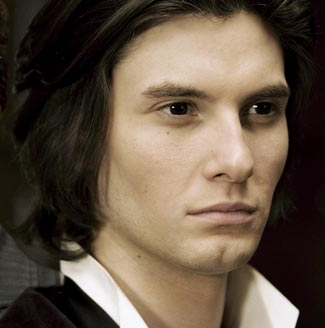

In [52]:
i = 26  # 7, 8
item = data_json[i]

# Item attributes
annotation_path = item["annotation_path"].split(f"{datatool_tag}/")[-1]
img_path = item["img_path"].split(f"{datatool_tag}/")[-1]
bbox = item["bbox"]

img = Image.open(os.path.join(path, img_path))
img_width, img_height = img.size
img_arr = np.array(img)
img

with open(os.path.join(path, annotation_path), 'r') as f:
  source_data = json.load(f)

# Get annotations data
vertices = np.array(source_data["vertices"])
view = np.array(source_data["model_view_matrix"])
projection = np.array(source_data["projection_matrix"])

# Pre-process
vertices_proj = reproject_vertices(vertices.copy(), projection, view, img_height)
img_crop = img_arr[bbox[1] : bbox[1] + bbox[3], bbox[0] : bbox[0] + bbox[2], :]  # crop image
vertices_crop = vertices_proj.copy()
vertices_crop[:,0] -= bbox[0] # adjust vertices based on cropping 
vertices_crop[:,1] -= bbox[1]

### Vertices 2 Landmarks: using FLAME Indices and Face models

In [53]:
device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")
flame_base_path = "./flame_utils/FLAME_PyTorch_bonseyes"

file_path = os.path.join(flame_base_path,"flame_config.json")
with open(file_path, 'r') as f:
  config = json.load(f)
config["static_landmark_embedding_path"] = 'model/landmark_embedding.npy'

config["device"] = device
config["flame_model_path"] = os.path.join(flame_base_path, config["flame_model_path"])
config["static_landmark_embedding_path"] = os.path.join(flame_base_path, config["static_landmark_embedding_path"])
config["dynamic_landmark_embedding_path"] = os.path.join(flame_base_path, config["dynamic_landmark_embedding_path"])
config = namedtuple('config', config.keys())(**config)

flamelayer = FLAME(config)
# flamelayer.lmk_faces_idx.shape
# flamelayer.lmk_bary_coords.shape
# flamelayer.dynamic_lmk_faces_idx.shape
# flamelayer.dynamic_lmk_bary_coords.shape

creating the FLAME Decoder
... Finished FLAME Decoder creation


In [54]:
lms_crop = flamelayer.flame_vertices2landmarks(vertices_crop)
lms_crop = lms_crop[0].detach().cpu().numpy()
lms_crop.shape

lms_proj = flamelayer.flame_vertices2landmarks(vertices_proj)
lms_proj = lms_proj[0].detach().cpu().numpy()
lms_proj.shape

(68, 3)

(68, 3)

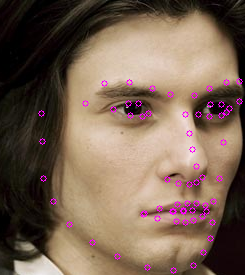

In [55]:
# Plot
img_plot = img_crop.copy()
# img_vertices = vertices_crop.copy()

# step = 1
# for coord in img_vertices[::step, :]:
#     img_plot = cv2.circle(img_plot, (int(coord[0]), int(coord[1])), radius=1, color=(255,255,255))

img_vertices = lms_crop.copy()

step = 1
for coord in img_vertices[::step, :]:
    img_plot = cv2.circle(img_plot, (int(coord[0]), int(coord[1])), radius=3, color=(255,0,255))

# img_plot = cv2.cvtColor(img_plot, cv2.COLOR_RGB2BGR)
Image.fromarray(img_plot)

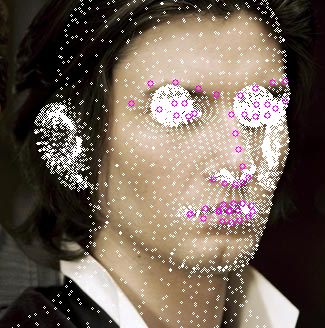

In [82]:
# Plot
img_plot = img_arr.copy()
img_vertices = vertices_proj.copy()

step = 1
for coord in img_vertices[::step, :]:
    img_plot = cv2.circle(img_plot, (int(coord[0]), int(coord[1])), radius=1, color=(255,255,255))

img_vertices = lms_proj.copy()

step = 1
for coord in img_vertices[::step, :]:
    img_plot = cv2.circle(img_plot, (int(coord[0]), int(coord[1])), radius=3, color=(255,0,255))

# img_plot = cv2.cvtColor(img_plot, cv2.COLOR_RGB2BGR)
Image.fromarray(img_plot)

### Landmarks 2 FLAME Parameters: Using FLAME Fitting

In [83]:
flame_base_path = "./flame_utils/flame_fitting_bonseyes"
lms_path = os.path.join(flame_base_path,"data/scan_lmks.npy")
lms_sample = np.load(lms_path)

lms_sample[:3]
lms_crop[:3]
lms_proj[:3]

array([[-0.0607802,  0.0309456,  0.0425312],
       [-0.0494252,  0.0369022,  0.0547772],
       [-0.0394189,  0.038468 ,  0.0599548]])

array([[ 85.79275 , 103.66503 ,  28.116657],
       [104.30203 ,  83.46416 ,  27.993969],
       [129.79015 ,  82.18931 ,  27.934769]], dtype=float32)

array([[131.79274 , 103.66503 ,  28.116657],
       [150.30203 ,  83.46416 ,  27.993969],
       [175.79015 ,  82.18931 ,  27.934769]], dtype=float32)

In [85]:
import sys
sys.path.append("./flame_utils/flame_fitting_bonseyes")
from flame_utils.flame_fitting_bonseyes.fit_lmk3d import fit_flame_to_lms

# lms_for_fit = lms_sample
# lmk_unit = "m"

# lms_for_fit = lms_crop
# lmk_unit = "na"

lms_for_fit = lms_proj
lmk_unit = "na"

shape_num = 300  # 100
expr_num = 100  # 50
maxiter = 2000
model_path = os.path.join(flame_base_path, "model/generic_model.pkl")
lmk_emb_path = os.path.join(flame_base_path, "model/flame_static_embedding.pkl")
mesh_v, mesh_f, params, scale_factor = fit_flame_to_lms(
                            lms_for_fit,
                            lmk_unit=lmk_unit,
                            shape_num=shape_num,
                            expr_num=expr_num,
                            maxiter=maxiter,
                            model_path=model_path,
                            lmk_emb_path=lmk_emb_path,
                        )

params.keys()
trans, pose = params["trans"], params["pose"]
shape, expr = params["shape"], params["expr"]
scale_factor_inv = 1 / scale_factor
mesh_v_scaled = scale_factor_inv * mesh_v

No scale specified - computing approximate scale based on the landmarks
Scale factor (unit='na'): -0.000709

step 1: start rigid fitting...
step 1: fitting done, in 28.963659 sec

step 2: start non-rigid fitting...
step 2: fitting done, in 56.262248 sec



dict_keys(['trans', 'pose', 'shape', 'expr', 'betas'])

In [87]:
# mesh_v_scaled_crop = mesh_v_scaled.copy()
# mesh_v_scaled_proj = mesh_v_scaled.copy()

Text(0.5, 1.0, 'Fitted')

Text(0.5, 1.0, 'GT')

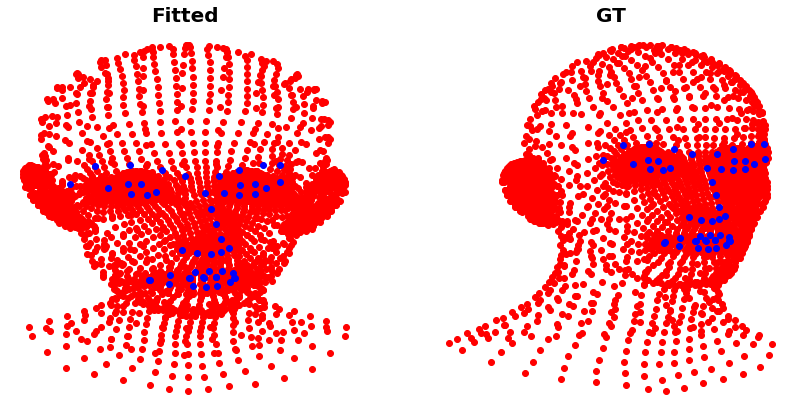

In [115]:
fig_s = 7
n_rows, n_cols = 1, 2
fit, ax = plt.subplots(n_rows, n_cols, figsize=(fig_s*n_cols, fig_s))
_ = [a.set_axis_off() for a in ax]

# ax[0].scatter(mesh_v_scaled_proj[:,0], -mesh_v_scaled_proj[:,1], color="red")
# ax[0].scatter(lms_proj[:,0], -lms_proj[:,1], color="blue")
# ax[0].set_title("Fitted", fontdict={'fontsize': 20, 'fontweight': 'bold'})

# ax[1].scatter(vertices_proj[:,0], -vertices_proj[:,1], color="red")
# ax[1].scatter(lms_proj[:,0], -lms_proj[:,1], color="blue")
# ax[1].set_title("GT", fontdict={'fontsize': 20, 'fontweight': 'bold'})

ax[0].scatter(mesh_v_scaled_crop[:,0], -mesh_v_scaled_crop[:,1], color="red")
ax[0].scatter(lms_crop[:,0], -lms_crop[:,1], color="blue")
ax[0].set_title("Fitted", fontdict={'fontsize': 20, 'fontweight': 'bold'})

ax[1].scatter(vertices_crop[:,0], -vertices_crop[:,1], color="red")
ax[1].scatter(lms_crop[:,0], -lms_crop[:,1], color="blue")
ax[1].set_title("GT", fontdict={'fontsize': 20, 'fontweight': 'bold'})

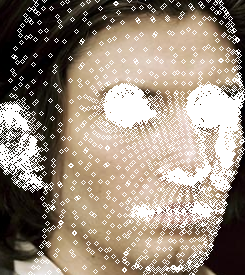

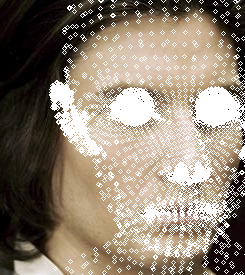

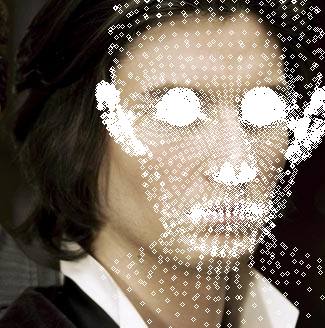

In [117]:
# Plot
img_plot = img_crop
img_vertices = vertices_crop
plot_mesh_on_image(img_plot, img_vertices)


img_plot = img_crop
img_vertices = mesh_v_scaled_crop
plot_mesh_on_image(img_plot, img_vertices)

img_plot = img_arr
img_vertices = mesh_v_scaled_proj
plot_mesh_on_image(img_plot, img_vertices)

#### Old Code

In [ ]:
# keys = ["vertices", "lms", "type"]
# data = dict.fromkeys(keys)
# plot_data = []
# data["vertices"], data["lms"], data["type"] = (
#             mesh_v_scaled_proj,
#             lms_proj,
#             "Fitted",
# )
# plot_data.append(data)

In [ ]:
n = 100
step = 25

vertices_crop.shape
vertices_crop[:n:step]

mesh_v_scaled.shape
mesh_v_scaled[:n:step]

mesh_v.shape
mesh_v[:n:step]